# 16-01. BERT 실습

<br>

#### TPU 초기화

In [ ]:
import tensorflow as tf
import os

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

#### TPU Strategy 셋팅
- `tf.distribute.Strategy`는 훈련을 여러 GPU 또는 여러 장비, 여러 TPU로 나누어 처리하기 위한 텐서플로 API
- 이 API를 사용하면 기존의 모델이나 훈련 코드를 분산처리를 할 수 있음



In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

<br>

#### 딥 러닝 모델의 컴파일
- 모델의 컴파일은 `strategy.scope` 내에서 이루어져야 함
- 이는 모델의 층을 쌓는 `create_model()`와 같은 함수를 만들어 `strategy.scope` 내에서 해당 함수를 호출하여 모델을 컴파일하는 방식으로 할 수 있음



<br>

- 모델의 층을 쌓는 `create_model()`라는 함수에 대해서

In [ ]:
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.Conv2D(256, 3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(10)])

- `with strategy.scope():` 다음에 들여쓰기를 하고,
  
  $\rightarrow$ `create_model()` 함수를 호출하고 모델을 컴파일
  
  **다시 말해 strategy.scope 내에서 모델을 컴파일**

- 이 모델을 fit() 하게되면 해당 모델은 TPU를 사용하며 학습
- 위의 1~3번까지의 코드를 실행하고, BERT와 커스텀 레이어에 대한 모델의 컴파일을 `strategy.scope` 내에서 진행


In [ ]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])

<br>

#### GPU 실습 코드로 되돌리기
* TPU로 실행한 코드들을 GPU 환경에서 실행하고 싶다면,

  모델의 층을 쌓고, 컴파일하는 코드를 제외한 TPU 진행만을 위한 코드들을 전부 제거


<br>

## `transformers`의 모델 클래스 불러오기
- `transformers` 라이브러리에서는 각종 태스크에 맞게 BERT 위에 출력층을 추가한 모델 클래스 구현체를 제공
- 아래의 구현체를 사용하면 사용자가 별도의 출력층을 설계할 필요없이 태스크에 맞게 모델을 로드하여 사용할 수 있음




<br>

###  다 대 일 유형
- **다 대 일(many-to-one) 유형은 텍스트 분류에 주로 사용되는 모델**

<br>

#### `transformers.TFBertForSequenceClassification.from_pretrained("모델 이름", num_labels="분류할 레이블의 개수")`


```python
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("모델 이름", num_labels="분류할 레이블의 개수")
```

<br>

### 다 대 다 유형
- **다 대 다(many-to-one) 유형은 다수의 입력에 대해서 다수의 출력이 필요할 때 사용하는 모델**

  $\rightarrow$ 개체명 인식

<br>

#### `transforemrs.TFBertForTokenClassification.from_pretrained("모델 이름", num_labels="분류할 레이블의 개수")`

```python
from transformers import TFBertForTokenClassification

model = TFBertForTokenClassification.from_pretrained("모델 이름", num_labels="분류할 레이블의 개수")

```

<br>

### 질의 응답 유형
* **질의 응답(Question Answering) 문제를 풀기 위해 사용하는 모델**

  $\rightarrow$ 기계 독해

<br>

#### `transformers .TFBertForQuestionAnswering.from_pretrained('모델 이름')`

<br>

```python
from transformers import TFBertForQuestionAnswering

model = TFBertForQuestionAnswering.from_pretrained('모델 이름')

```

<br>

## Google BERT를 이용한 네이버 영화 리뷰 분류

In [ ]:
pip install transformers

In [ ]:
import transformers

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

- 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78aea721bd30>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 데이터 정제

In [ ]:
train_data = train_data.dropna(how = 'any')
train_data = train_data.reset_index(drop=True)
print(train_data.isnull().values.any())

False


In [ ]:
test_data = test_data.dropna(how = 'any')
test_data = test_data.reset_index(drop=True)
print(test_data.isnull().values.any())

False


In [ ]:
print(len(train_data))

149995


In [ ]:
print(len(test_data))

49997


<br>

#### 토크나이저 생성

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

- 토크나이저 확인

In [ ]:
print(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

[101, 9356, 11018, 31605, 31605, 110589, 71568, 118913, 11018, 9576, 119281, 9786, 79940, 23811, 40364, 9520, 23160, 102]


In [ ]:
print(tokenizer.tokenize("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

['보', '##는', '##내', '##내', '그대로', '들어', '##맞', '##는', '예', '##측', '카', '##리스', '##마', '없는', '악', '##역']


In [ ]:
tokenizer.decode(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

'[CLS] 보는내내 그대로 들어맞는 예측 카리스마 없는 악역 [SEP]'

In [ ]:
for elem in tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"):
  print(tokenizer.decode(elem))

[ C L S ]
보
# # 는
# # 내
# # 내
그 대 로
들 어
# # 맞
# # 는
예
# # 측
카
# # 리 스
# # 마
없 는
악
# # 역
[ S E P ]


In [ ]:
print(tokenizer.tokenize("전율을 일으키는 영화. 다시 보고싶은 영화"))

['전', '##율', '##을', '일', '##으', '##키는', '영화', '.', '다시', '보고', '##싶', '##은', '영화']


In [ ]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102]


In [ ]:
for elem in tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"):
  print(tokenizer.decode(elem))

[ C L S ]
전
# # 율
# # 을
일
# # 으
# # 키 는
영 화
.
다 시
보 고
# # 싶
# # 은
영 화
[ S E P ]


In [ ]:
for elem in tokenizer.encode("happy birthday~!"):
  print(tokenizer.decode(elem))

[ C L S ]
h a p p y
b i r t h d a y
~
!
[ S E P ]


- 문장 시작 토큰 [CLS]와 문장 구분 토큰 [SEP]의 토큰 아이디

In [ ]:
print(tokenizer.decode(101))

[ C L S ]


In [ ]:
print(tokenizer.decode(102))

[ S E P ]


In [ ]:
print(tokenizer.cls_token, ':', tokenizer.cls_token_id)
print(tokenizer.sep_token, ':' , tokenizer.sep_token_id)

[CLS] : 101
[SEP] : 102


- 패딩 토큰 [PAD]의 토큰 아이디

In [ ]:
print(tokenizer.pad_token, ':', tokenizer.pad_token_id)

[PAD] : 0


<br>

#### 패딩
-  문장 최대 길이만큼 패딩

In [ ]:
max_seq_len = 128

In [ ]:
encoded_result = tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화", max_length=max_seq_len, pad_to_max_length=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(encoded_result)
print('길이 :', len(encoded_result))

[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
길이 : 128


<br>

#### 어텐션 마스크 (Attention Mask)

<img src='https://wikidocs.net/images/page/115055/%EA%B7%B8%EB%A6%BC11.PNG'>

- BERT를 실제로 실습하게 되면 어텐션 마스크라는 시퀀스 입력이 추가로 필요

- 어텐션 마스크는 BERT가 어텐션 연산을 할 때, 불필요하게 패딩 토큰에 대해서 어텐션을 하지 않도록,

  실제 단어와 패딩 토큰을 구분할 수 있도록 알려주는 입력

  0과 1 두 가지 값을 가짐

  - 숫자 1 : 해당 토큰은 실제 단어이므로 마스킹을 하지 않는다라는 의미

  - 숫자 0 : 해당 토큰은 패딩 토큰이므로 마스킹을 한다는 의미

- 위의 그림과 같이 실제 단어의 위치에는 1, 패딩 토큰의 위치에는 0의 값을 가지는 시퀀스를 만들어 BERT의 또 다른 입력으로 사용


In [ ]:
valid_num = len(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))
print(valid_num)
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))
print(tokenizer.decode(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화")))

15
[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102]
[CLS] 전율을 일으키는 영화. 다시 보고싶은 영화 [SEP]


In [ ]:
print(valid_num * [1] + (max_seq_len - valid_num) * [0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<br>

#### 세그먼트 임베딩

<img src='https://wikidocs.net/images/page/115055/%EA%B7%B8%EB%A6%BC7.PNG'>

- 문장 구분을 위해서 BERT는 세그먼트 임베딩이라는 또 다른 임베딩 층(Embedding layer)을 사용
- 첫번째 문장에는 Sentence 0 임베딩, 두번째 문장에는 Sentence 1 임베딩을 더해주는 방식이며, 임베딩 벡터는 두 개만 사용

  $→$ **1개의 입력 문장에 대한 텍스트 분류이기에, 모든 임베딩 값을 0으로 통일**

In [ ]:
print([0] * max_seq_len)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<br>

#### 인코딩된 텍스트에의 어텐션 마스킹 $\rightarrow$ 세그먼트 임베딩 생성을 하는 함수

In [ ]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

<br>

#### 훈련/테스트 데이터에 대한 어텐션 마스킹

In [ ]:
train_X, train_y = convert_examples_to_features(train_data['document'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 149995/149995 [01:57<00:00, 1272.85it/s]


In [ ]:
test_X, test_y = convert_examples_to_features(test_data['document'], test_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 49997/49997 [00:19<00:00, 2541.69it/s]


<br>

* 어텐션 마스킹 확인
  - 최대 길이: 128


In [ ]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [   101   9519   9074 119005    119    119   9708 119235   9715 119230
  16439  77884  48549   9284  22333  12692    102      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<br>

#### BERT 모델 로드

In [ ]:
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

<br>

- **BERT모델의 입력층, 어텐션 마스킹층, 세그먼트 임베딩층 추가**

In [ ]:
max_seq_len = 128

In [ ]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

In [ ]:
print(outputs)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [ ]:
print(outputs[0])

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")


In [ ]:
print(outputs[1])

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


<br>

#### TPU 구동 및 모델 생성

- 모델 생성 클래스

In [ ]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForSequenceClassification, self).__init__()

        # 입력 받은 BERT 모델 로드
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)

        # 이진 분류 출력층 생성
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

- TPU 환경 설정

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
with strategy.scope():
  model = TFBertForSequenceClassification("bert-base-multilingual-cased")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.BinaryCrossentropy()
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

<br>

#### 모델 적합

In [ ]:
model.fit(train_X, train_y, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
1875/1875 [==============================] - 344s 128ms/step - loss: 0.4077 - accuracy: 0.8076 - val_loss: 0.3367 - val_accuracy: 0.8551
Epoch 2/2
1875/1875 [==============================] - 229s 122ms/step - loss: 0.3172 - accuracy: 0.8618 - val_loss: 0.3214 - val_accuracy: 0.8582


In [ ]:
results = model.evaluate(test_X, test_y, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 22s 330ms/step - loss: 0.3258 - accuracy: 0.8581
test loss, test acc:  [0.3257826864719391, 0.8581115007400513]


<br>

#### 모델 평가

In [ ]:
def sentiment_predict(new_sentence):
  input_id = tokenizer.encode(new_sentence, max_length=max_seq_len, pad_to_max_length=True)

  padding_count = input_id.count(tokenizer.pad_token_id)
  attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
  token_type_id = [0] * max_seq_len

  input_ids = np.array([input_id])
  attention_masks = np.array([attention_mask])
  token_type_ids = np.array([token_type_id])

  encoded_input = [input_ids, attention_masks, token_type_ids]
  score = model.predict(encoded_input)[0][0]
  print(score)

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict("보던거라 계속보고있는데 전개도 느리고 주인공인 은희는 한두컷 나오면서 소극적인모습에 ")

1/1 [==============================] - 10s 10s/step
0.117415756
88.26% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict("스토리는 확실히 실망이였지만 배우들 연기력이 대박이였다 특히 이제훈 연기 정말 ... 이 배우들로 이렇게밖에 만들지 못한 영화는 아쉽지만 배우들 연기력과 사운드는 정말 빛났던 영화. 기대하고 극장에서 보면 많이 실망했겠지만 평점보고 기대없이 집에서 편하게 보면 괜찮아요. 이제훈님 연기력은 최고인 것 같습니다")

1/1 [==============================] - 1s 742ms/step
0.95116496
95.12% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict("별 똥같은 영화를 다 보네. 개별로입니다.")

1/1 [==============================] - 1s 630ms/step
0.13549471
86.45% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict("이 영화 존잼입니다 대박.")

1/1 [==============================] - 1s 661ms/step
0.96983546
96.98% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 1s 762ms/step
0.56645006
56.65% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 1s 592ms/step
0.035006046
96.50% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 1s 601ms/step
0.064368755
93.56% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 1s 588ms/step
0.79921585
79.92% 확률로 긍정 리뷰입니다.



<br>

## KoBERT를 이용한 네이버 영화 리뷰 분류

In [113]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

<br>

#### 데이터 로드

In [64]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78ae80da3af0>)

In [65]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [66]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [67]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [68]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 50000


In [69]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<br>

- 중복값 제거

In [70]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [71]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [72]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<br>

- 클래스 분포 확인

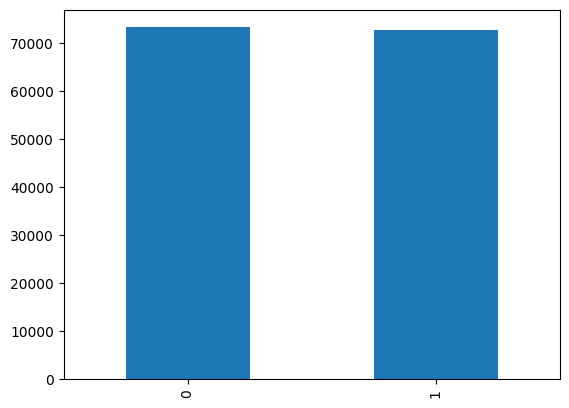

In [73]:
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [74]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [75]:
print(train_data.isnull().values.any())

True


In [76]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [77]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


- 결측값 제거

In [78]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [79]:
print(len(train_data))

146182


<br>

#### 어텐션 마스킹 & 세그먼트 임베딩
#### KoBERT 토크나이저를 이용한 정수 인코딩

In [ ]:
!pip install transformers

In [114]:
import transformers
from transformers import BertTokenizerFast

In [83]:
tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

<br>

- **토크나이저의 `padding`을  `TRUE`로 설정 $\rightarrow$ 문장 최대길이에 맞는 패딩 $\rightarrow$ 어텐션 마스킹**

- `type_ids`는 지금 풀고자 하는 문제에서 문장의 종류의 개수를 의미하는데,
  
  일반적으로 두 개 이상의 문장을 가지고 푸는 문제일 경우에는 [0, 0, 0, 0, 1, 1, 1, 1] 이런 식의 값이 들어가지만 네이버 영화 리뷰는 문장 1개를 보고 푸는 문제라서 [0, 0, 0, 0, 0, 0, 0, 0]이 들어감

In [84]:
test_data = test_data.dropna(how = 'any')

In [85]:
print(len(test_data))

49997


In [86]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

In [87]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [88]:
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [89]:
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [90]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [91]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### 데이터셋 생성

In [115]:
import tensorflow as tf

In [93]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

<br>

#### 모델 생성 & 컴파일

In [116]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [98]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br>

#### 모델 적합
- 콜백 옵션 조기종료 설정

In [96]:
callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

In [109]:
model.fit(
    train_dataset.shuffle(10000).batch(32), epochs=5, batch_size=64,
    validation_data = val_dataset.shuffle(10000).batch(64),
    callbacks = [callback_earlystop]
)

Epoch 1/5


KeyboardInterrupt: 

In [101]:
model.evaluate(val_dataset.batch(1024))

49/49 [==============================] - 1047s 21s/step - loss: 0.3141 - accuracy: 0.8695


[0.3141085207462311, 0.8694721460342407]

<br>

#### 모델 저장

In [102]:
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

('nsmc_model/bert-base/tokenizer_config.json',
 'nsmc_model/bert-base/special_tokens_map.json',
 'nsmc_model/bert-base/vocab.txt',
 'nsmc_model/bert-base/added_tokens.json',
 'nsmc_model/bert-base/tokenizer.json')

<br>

#### 모델 로드 및 테스트

In [ ]:
from transformers import TextClassificationPipeline

- 모델 로드

In [ ]:
loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at nsmc_model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nsmc_model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


<br>

#### 모델 평가

In [ ]:
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]

[{'label': 'LABEL_0', 'score': 0.746947169303894},
 {'label': 'LABEL_1', 'score': 0.25305283069610596}]

In [ ]:
text_classifier('오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함')[0]

[{'label': 'LABEL_0', 'score': 0.08093070983886719},
 {'label': 'LABEL_1', 'score': 0.9190692901611328}]

<br>

## KorNLI (다중 클래스 분류)
- **NLI는 두 개의 문장이 주어지면 수반(entailment) 관계인지, 모순(contradiction) 관계인지, 중립(neutral) 관계인지를 맞추는 문제**

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<br>

#### 데이터 로드
- 훈련 데이터

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/multinli.train.ko.tsv", filename="multinli.train.ko.tsv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/snli_1.0_train.ko.tsv", filename="snli_1.0_train.ko.tsv")

('snli_1.0_train.ko.tsv', <http.client.HTTPMessage at 0x7d18b7e6e3e0>)

- 검증 데이터

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv", filename="xnli.dev.ko.tsv")

('xnli.dev.ko.tsv', <http.client.HTTPMessage at 0x7d18b7e6e320>)

- 평가 데이터

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.test.ko.tsv", filename="xnli.test.ko.tsv")

('xnli.test.ko.tsv', <http.client.HTTPMessage at 0x7d18b7e6e680>)

In [5]:
train_snli = pd.read_csv("snli_1.0_train.ko.tsv", sep='\t', quoting=3)
train_xnli = pd.read_csv("multinli.train.ko.tsv", sep='\t', quoting=3)
val_data = pd.read_csv("xnli.dev.ko.tsv", sep='\t', quoting=3)
test_data = pd.read_csv("xnli.test.ko.tsv", sep='\t', quoting=3)

In [6]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [7]:
train_xnli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


- 훈련 데이터 결합 후 섞기

In [8]:
train_data = train_snli.append(train_xnli)
train_data = train_data.sample(frac=1)

<ipython-input-8-106fa8c3e2e3>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_snli.append(train_xnli)


In [9]:
train_data.head()

,sentence1,sentence2,gold_label
185169,오토바이를 탄 두 남자가 빈 거리를 운전하고 있다.,두 남자가 오토바이를 운전하고 있다.,entailment
502149,파란 유니폼을 입은 여자가 서서 아래를 내려다본다.,여자가 일하고 있다.,neutral
132107,"한 무리의 인도 남성들은 3명의 학교 아이들, 한 명의 어린 소년, 그리고 두 명의...",아무도 자고 있지 않다,contradiction
273713,"피어싱과 목걸이, 옥수수를 머리에 이고 있는 아프리카 여성.",그 아프리카 여성은 머리에 호박을 가지고 있다.,contradiction
277777,베르겐 카운티 법률 서비스 책임자로서 400만 달러의 예산이 3군청 부국장이 된다.,3개 카운티 사무소의 예산은 베르겐 카운티 서비스의 예산보다 거의 두 배나 크다.,neutral


In [10]:
val_data.head()

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction


In [11]:
test_data.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


<br>

#### 데이터 정제
- 결측값 및 중복값 제거

In [12]:
def drop_na_and_duplciates(df):
  df = df.dropna()
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)
  return df

In [13]:
train_data = drop_na_and_duplciates(train_data)
val_data = drop_na_and_duplciates(val_data)
test_data = drop_na_and_duplciates(test_data)

<br>

#### KoBERT 토큰화

- 모델 로드

In [14]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


- 문장 최대 길이

In [15]:
max_seq_len = 128

- 2개의 입력 문장에 대한 어텐션 마스킹 & 세그먼트 임베딩

In [16]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [ ]:
X_train = convert_examples_to_features(train_data['sentence1'], train_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

In [18]:
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    2 12406  2138  1763   864  3997  2116  1189  4142  2138  5390 19521
  1513  2062    18     3   864  3997  2116 12406  2138  5390 19521  1513
  2062    18     3     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [19]:
X_val = convert_examples_to_features(val_data['sentence1'], val_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 2490/2490 [00:01<00:00, 1720.72it/s]


In [20]:
# 최대 길이: 128
input_id = X_val[0][0]
attention_mask = X_val[1][0]
token_type_id = X_val[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    2  3673   636  2116  1041  2371  2062    16     6  4122    16  1535
  1458 10283    18     6     3   636  2259  3741  4942  2116   636  2138
  4105  2223  2155  6000  4122  2170  2318  4117  2138   572  2359  2062
    18     3     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [21]:
X_test = convert_examples_to_features(test_data['sentence1'], test_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 5010/5010 [00:02<00:00, 1747.58it/s]


<br>

#### 타겟 라벨 인코딩
- **타겟 (2개의 문장간 관계)가 수반(entailment)일 시 1,**

  **모순(contradiction)관계일 시 0,**

  **중립(neutral)관계일 시 2로 라벨 인코딩**

In [22]:
train_label = train_data['gold_label'].tolist()
val_label = val_data['gold_label'].tolist()
test_label = test_data['gold_label'].tolist()

In [23]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label)
y_val = idx_encode.transform(val_label)
y_test = idx_encode.transform(test_label)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{'contradiction': 0, 'entailment': 1, 'neutral': 2}
{0: 'contradiction', 1: 'entailment', 2: 'neutral'}


<br>

#### TPU 설정 하에서의 모델 생성

- TPU 구동

In [24]:
from transformers import TFBertForSequenceClassification

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.59.221.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.221.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

<br>

- 모델 생성 및 컴파일

In [ ]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br>

#### 모델 적합 및 평가
- 조기 종료 옵션 설정

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

In [ ]:
model.fit(
    X_train, y_train, epochs=2, batch_size=32, validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

Epoch 1/2


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]


29432/29432 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.7874

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 128) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]


29432/29432 [==============================] - 2321s 76ms/step - loss: 0.5343 - accuracy: 0.7874 - val_loss: 0.5494 - val_accuracy: 0.7711
Epoch 2/2
29432/29432 [==============================] - 2181s 74ms/step - loss: 0.4352 - accuracy: 0.8329 - val_loss: 0.5446 - val_accuracy: 0.7831


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, batch_size=1024)[1]))

5/5 [==============================] - 19s 2s/step - loss: 0.5414 - accuracy: 0.7749

 테스트 정확도: 0.7749
